In [44]:
# display, transform, read, split ...
import numpy as np
import matplotlib.pyplot as plt
import splitfolders

# tensorflow
import tensorflow.keras as keras
import tensorflow as tf

# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import  Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Dropout is a regularization technique to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.
from tensorflow.keras.layers import Dropout, BatchNormalization

In [41]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,       # Rotate the image by up to 20 degrees
    width_shift_range=0.2,   # Shift the image width by up to 20% of the width
    height_shift_range=0.2,  # Shift the image height by up to 20% of the height
    shear_range=0.2,         # Shear angle in a counter-clockwise direction in degrees
    zoom_range=0.2,          # Zoom in/out by up to 20%
    horizontal_flip=True,    # Flip the image horizontally
    fill_mode='nearest'      # Fill in pixels that are empty after transformation
)


test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

# define classes name
class_names = ['Anger and aggression','anxiety','happy','sad']

In [45]:
# Load data
train_generator = train_datagen.flow_from_directory(
    directory="./anamelClassification.v1i.multiclass/train",
    classes=class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

valid_generator = val_datagen.flow_from_directory(
    directory="./anamelClassification.v1i.multiclass/valid/",
    classes=class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    directory="./anamelClassification.v1i.multiclass/test",
    classes=class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 400 images belonging to 4 classes.
Found 50 images belonging to 4 classes.
Found 50 images belonging to 4 classes.


In [46]:
resnet_50 = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze initial layers
for layer in resnet_50.layers:
    layer.trainable = False

# Add custom layers
x = resnet_50.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

# Create the model
model = Model(inputs=resnet_50.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Initial training
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

In [47]:

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10, 
    callbacks=[early_stopping, reduce_lr]
)


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3775 - loss: 1.8459

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 66s 4s/step - accuracy: 0.3869 - loss: 1.8147 - val_accuracy: 0.2800 - val_loss: 2.0296 - learning_rate: 0.0010
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8233 - loss: 0.5145 - val_accuracy: 0.6400 - val_loss: 0.8394 - learning_rate: 0.0010
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8651 - loss: 0.3544 - val_accuracy: 0.7200 - val_loss: 0.7739 - learning_rate: 0.0010
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.9199 - loss: 0.2223 - val_accuracy: 0.8600 - val_loss: 0.6152 - learning_rate: 0.0010
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.9410 - loss: 0.1623 - val_accuracy: 0.9000 - val_loss: 0.3400 - learning_rate: 0.0010
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.9450 - loss: 0.1455 - val_accuracy: 0.8800 - val_loss: 0.3357 - learning_rate: 0.0010
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.9577 - loss: 0.1246 - val_accuracy: 0.8800 - va

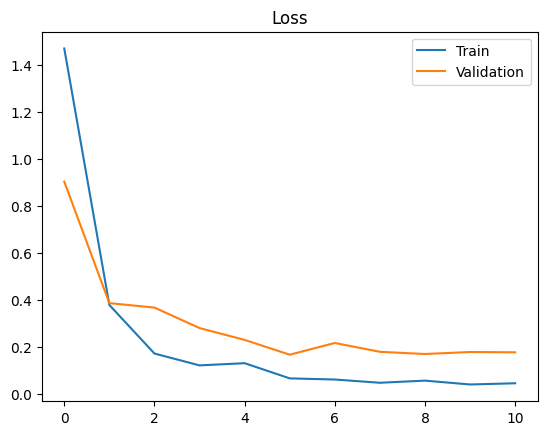

In [48]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

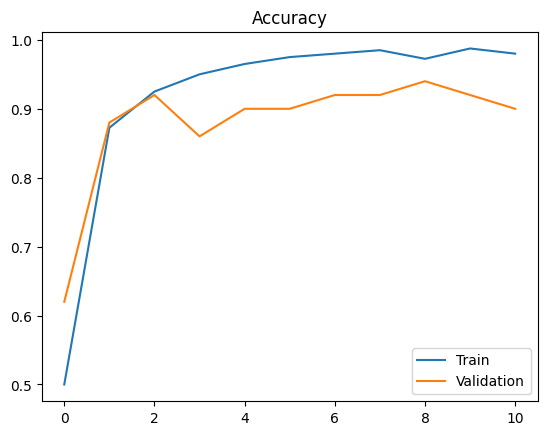

In [49]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [50]:
test_loss, test_acc = model.evaluate(test_generator)
print("The best accuracy is: ", test_acc*100)
print("The test loss is: ", test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9629 - loss: 0.2218
The best accuracy is:  95.99999785423279
The test loss is:  0.2842656970024109


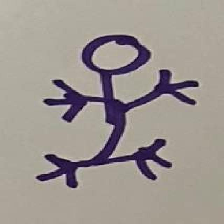

In [55]:
img = tf.keras.preprocessing.image.load_img('./anamelClassification.v1i.multiclass/test/Anger and aggression/photo_82_2024-04-05_12-16-52_jpg.rf.218c300be1d0544662f84acd899b6908.jpg', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array]) 
img


In [56]:
# generate predictions for samples
predictions = model.predict(img_array)
print(predictions)
# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
# transform classes number into classes name
class_names[class_id.item()]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
[[9.7787219e-01 3.6547784e-04 1.5840132e-02 5.9223170e-03]]


'Anger and aggression'

In [58]:
model.save('ResNet50.h5')